In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import spacy

import ssl
import socket

In [2]:
mails = pd.read_csv('CEAS_08.csv')
print(mails.head(3))

                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   

                        receiver                             date  \
0    user4@gvc.ceas-challenge.cc  Tue, 05 Aug 2008 16:31:02 -0700   
1  user2.2@gvc.ceas-challenge.cc  Tue, 05 Aug 2008 18:31:03 -0500   
2  user2.9@gvc.ceas-challenge.cc  Tue, 05 Aug 2008 20:28:00 -1200   

                     subject  \
0  Never agree to be a loser   
1     Befriend Jenna Jameson   
2       CNN.com Daily Top 10   

                                                body  label  urls  
0  Buck up, your troubles caused by small dimensi...      1     1  
1  \nUpgrade your sex and pleasures with these te...      1     1  
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1     1  


In [3]:
mails.drop_duplicates(subset=['subject', 'sender'],
                      keep='first',
                      inplace=True)

# print(mails.isnull().sum().sort_values())
mails.dropna(subset=['subject'], inplace=True)

In [4]:
def strip_for_mail(sender):
    start_symbol = '<'
    end_symbol = '>'
    if start_symbol in sender:
        start_index = sender.index(start_symbol) + 1
        end_index = sender.index(end_symbol)
        output = sender[start_index:end_index]
        return output
    else:
        return sender


mails['sender_mail'] = mails['sender'].apply(strip_for_mail)

In [5]:
mapping = {
    0: 'legit',
    1: 'malicious'
}

mails['label'] = mails['label'].map(mapping)

mails = mails[['sender_mail', 'subject', 'body', 'label']]
mails.columns = ['sender_mail', 'subject', 'body', 'phishing']

# print(mails.info())

In [6]:
# Shufflujemy sobie
mails = mails.sample(frac=1).reset_index(drop=True)

# Na potrzeby obliczeń zmniejszamy
cut_rows_to = 100
mails = mails.iloc[:cut_rows_to, :]
print(mails.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sender_mail  100 non-null    object
 1   subject      100 non-null    object
 2   body         100 non-null    object
 3   phishing     100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB
None


In [7]:
print(mails.body[0])
def extract_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    matches = re.findall(url_pattern, text)

    return matches, len(matches)

mails[['extracted_urls', 'urls_count']] = mails['body'].apply(lambda x:
                                                              pd.Series(extract_urls(x)))
print(mails.head(3))




Do not ignore me please,
I found your email somewhere and now decided to write you.
Let me know if you do not mind. If you want I can send you some pictures of me.
I am a nice pretty girl. Don't reply to this email. 
Email me direclty at dkrystle@cardrealc.com



                   sender_mail                                subject  \
0  aorugceqzdlh@mystarship.com                        hi from krystle   
1            mjl@ix.netcom.com  Re: [Dixielandjazz] Dixieland Beatles   
2      okbdrnfsbrqqp@gmail.com                Re: [ie-rant] Re: pubs.   

                                                body   phishing  \
0  \n\nDo not ignore me please,\nI found your ema...  malicious   
1  Not an answer to the question, but one of my m...      legit   
2  I like Anseo on Camden street, the vibe is sim...      legit   

                                      extracted_urls  urls_count  
0                                                 []           0  
1  [http://ml.islandnet.com/mailman/li

## 1. Certyfikat SSL

In [8]:
def is_https(urls):
    if not urls:
        return 'None'
    
    if urls[0][:5] == 'https':
        return 'https'
    else:
        return 'http'
    

mails['protocol'] = mails['extracted_urls'].apply(is_https)

protocols = pd.CategoricalDtype(['None', 'http', 'https'],
                                ordered=True)

mails['protocol'] = mails['protocol'].astype(protocols)
# print(mails.head())

In [9]:
val_count = mails[['protocol', 'phishing']].value_counts()

data = {
    "malicious": {
        protocol: count for (protocol, phishing),
                    count in val_count.items() if phishing == 'malicious'
    },
    "legit": {
        protocol: count for (protocol, phishing),
                    count in val_count.items() if phishing == 'legit'
    }
}

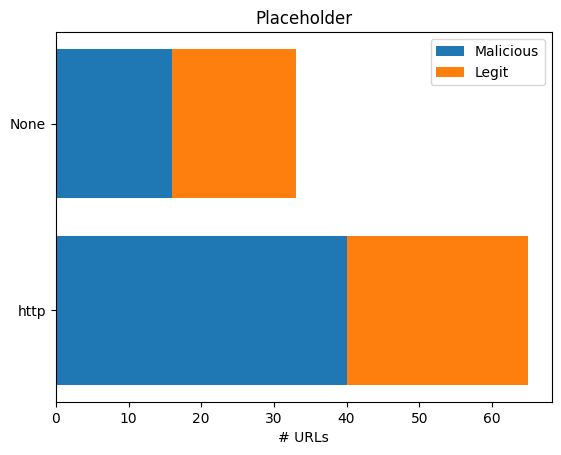

In [10]:

categories = list(data.keys())
protocols = list(data["malicious"].keys())
values_malicious = [data["malicious"][protocol] for protocol in protocols]
values_legit = [data["legit"][protocol] for protocol in protocols]

fig, ax = plt.subplots()
ax.barh(protocols, values_malicious, label='Malicious')
ax.barh(protocols, values_legit, label='Legit', left=values_malicious)

ax.set_xlabel('# URLs')
ax.set_title('Placeholder')

plt.legend()
plt.show()

## Autentyczność certyfikatu

In [11]:
def get_domain_from_url(url):
    pass
# ZROBIĆ


def get_ssl_certificate(url):
    if not url:
        return 'no url'

    # Get domain out of url
    pattern = re.compile(r'https?://([^/]+)')
    match = pattern.match(url[0])
    
    if match:
        domain = match.group(1)
    else:
        return 'url error'

    # Get certificate
    try:
        connection = socket.create_connection((domain, 443))
        context = ssl.create_default_context()
        with context.wrap_socket(connection, server_hostname=domain) as sock:
            certificate = sock.getpeercert()
    except Exception:
        return 'checking error'
    
    certificate_short = {
        'Issuer': {
            'Common Name': certificate['issuer'][2][0][1],
            'Organization': certificate['issuer'][1][0][1],  
        },
        'Expiration_date': certificate['notAfter']
    }

    #Lista jest niekompletna, TODO: UZUPEŁNIĆ
    trusted_organizations = ['sectigo', 'comodo', 'digicert', 'ssl.com', 'alphassl', 'entrust', 'globalsign']
    

    # .split(' ')[0] bo trzeba rozwiązać problem porównywania organizacji.
    if certificate_short['Issuer']['Organization'].split(' ')[0].lower() in trusted_organizations:
        return 'thrustworthy'
    else:
        return 'uncertain'
    
    

In [12]:
mails['ssl_confidence'] = mails['extracted_urls'].apply(get_ssl_certificate)
categories = pd.CategoricalDtype(['no url', 'url error', 'checking error', 'uncertain', 'trustworthy'],
                                 ordered=True)
mails['ssl_confidence'] = mails['ssl_confidence'].astype(categories)
print(mails.info())
print(mails['ssl_confidence'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sender_mail     100 non-null    object  
 1   subject         100 non-null    object  
 2   body            100 non-null    object  
 3   phishing        100 non-null    object  
 4   extracted_urls  100 non-null    object  
 5   urls_count      100 non-null    int64   
 6   protocol        100 non-null    category
 7   ssl_confidence  86 non-null     category
dtypes: category(2), int64(1), object(5)
memory usage: 5.3+ KB
None
['no url', 'checking error', 'uncertain', NaN, 'url error']
Categories (5, object): ['no url' < 'url error' < 'checking error' < 'uncertain' < 'trustworthy']


## Czarna lista słów

## Odnośniki przekierowywujące

## Ukrywane odnośniki

## Adres IP wewnątrz odnośnika

In [35]:
import re

def contains_ip(url):
    if not url:
        return 'no url'

    ip_pattern = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b|\b(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}\b')
    ips = ip_pattern.findall(url[0])

    if ips:
        return 'include'
    else:
        return 'exclude'

url_to_check = 'https://example.com/192.168.1.1/page'
print(url_to_check, contains_ip(url_to_check))
mails['ip_in_url'] = mails['extracted_urls'].apply(contains_ip)
categories = pd.CategoricalDtype(['no url', 'exclude', 'include'], ordered=True)
mails['ip_in_url'] = mails['ip_in_url'].astype(categories)

https://example.com/192.168.1.1/page exclude
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sender_mail     100 non-null    object  
 1   subject         100 non-null    object  
 2   body            100 non-null    object  
 3   phishing        100 non-null    object  
 4   extracted_urls  100 non-null    object  
 5   urls_count      100 non-null    int64   
 6   protocol        100 non-null    category
 7   ssl_confidence  86 non-null     category
 8   ip_in_url       100 non-null    category
dtypes: category(3), int64(1), object(5)
memory usage: 5.6+ KB
None
                   sender_mail                                subject  \
0  aorugceqzdlh@mystarship.com                        hi from krystle   
1            mjl@ix.netcom.com  Re: [Dixielandjazz] Dixieland Beatles   
2      okbdrnfsbrqqp@gmail.com                Re: [ie-rant]

## Liczba odwiedzin witryny

## Wiek strony internetowej

In [28]:

# import whois
# from datetime import datetime

# def get_website_creation_date(url):
#     if not url:
#         return None

#     # Get url out of url
#     pattern = re.compile(r'https?://([^/]+)')
#     match = pattern.match(url[0])
    
#     if match:
#         url = match.group(1)
#     else:
#         return None

#     try:
#         url_info = whois.whois(url)
        
#         if isinstance(url_info.creation_date, list):
#             creation_date = url_info.creation_date[0]
#         else:
#             creation_date = url_info.creation_date

#         if creation_date:
#             creation_date = datetime.strptime(str(creation_date), '%Y-%m-%d %H:%M:%S')
#             return creation_date
#         else:
#             return None

#     except Exception as e:
#         print(f"Error: {e}")
#         return None

# url_to_check = ['https://aniagotuje.pl/']
# creation_date = get_website_creation_date(url_to_check)

# if creation_date:
#     print(f"The website '{url_to_check}' was created on: {creation_date}")
# else:
#     print(f"Failed to retrieve creation date for '{url_to_check}'")

Error: module 'whois' has no attribute 'whois'
Failed to retrieve creation date for '['https://aniagotuje.pl/']'


## Adres e-mail nadawcy